# Otimizador de Energia LoRa para Rádio SX1276

## Objetivo
Implementar um algoritmo evolutivo para minimizar o consumo de energia de transmissões LoRa, respeitando uma margem mínima de RSSI. Os indivíduos da população são combinações de parâmetros do LoRa (potência, SF e BW) e a função de avaliação penaliza soluções inválidas ou ineficientes.

## Multiplas Variáveis
Determinar a configuração ótima de:
- Potência de Transmissão (dBm)
- Fator de Espalhamento (SF)
- Largura de Banda (BW)

Que minimize a energia de transmissão garantindo que a margem do link (RSSI - Sensibilidade) permaneça acima de um limite definido.

## Restrições
- Potência, SF e BW são valores discretos conforme apresentado no datasheet do componente
- Margem mínima do link para garantir folga
- Penalizações são aplicadas quando essas restrições são violadas

## Principais Características do Trabalho
- Utiliza a biblioteca DEAP para otimização evolutiva usando Algoritmo Genético Simples (Simple Genetic Algorithm)
- Incorpora tabelas de sensibilidade do SX1276 extraídas do datasheet
- Cálculo de energia baseado em interpolação do consumo de corrente e tempo de transmissão
- Execução paralela usando multiprocessing
- Geração de gráficos com energia (Joule), potência (de transmissão em dBm), SF (fator de espalhamento) e BW (largura de banda) para todos os valores de RSSI

## Limites do Link (atenuação do sinal em dB)
O script processará valores de RSSI de -161 dBm a -90 dBm e exibirá gráficos com os parâmetros ótimos e o consumo de energia correspondente.

## Parâmetros Suportados pelo SX1276
A tabela abaixo mostra os valores discretos suportados para os principais parâmetros de transmissão do rádio SX1276:

| Fator de Espalhamento (SF) | Largura de Banda (kHz)                                  | Taxa de Codificação (CR)  | Potência de Saída (dBm) |
|----------------------------|---------------------------------------------------------|---------------------------|-------------------------|
| 6, 7, 8 ,9 10, 11, 12      | 7.8, 10.4, 15.6, 20.8, 31.25, 41.7, 62.5, 125, 250, 500 | 4/5, 4/6, 4/7, 4/8        | 2 a 20                  |

Essas faixas definem os limites do processo de otimização e refletem as configurações práticas permitidas pelo SX1276 conforme especificado em seu datasheet.

## Parâmetros de Configuração para a otimização
- Tamanho do payload: 20 bytes
- Taxa de Codificação (CR): 4/5
- Margem de segurança do link: 6dB

## Equações Utilizadas
### Taxa de Símbolos
`Rs = BW / 2^SF`

### Tempo de Símbolo
`Ts = 1 / Rs`

### Símbolos do Payload
`npayload = 8 + max(ceil((8*PL - 4*SF + 28 + 16*CRC - 20*IH) / (4*(SF - 2*DE))) * (CR + 4), 0)`

### Tempo de Transmissão
`Tpacket = (npreamble + 4.25) * Tsym + npayload * Tsym`

### Energia
`E = I_mA * Vcc * Tpacket` (Joule)

## Tabela de Sensibilidade
Interpolada a partir de valores do datasheet para combinações de SF e BW.

## Consumo de Corrente
A corrente em mA é calculada com base em interpolação polinomial dos valores do datasheet.

## Preparo do ambiente
```bash
python3 -m venv .venv
source .venv/bin/activate
pip install -r requirements.txt
```

## Referências Bibliográficas

    Semtech SX1276 Datasheet. Disponível em: https://www.semtech.com/products/wireless-rf/lora-transceivers/sx1276

    DEAP: Distributed Evolutionary Algorithms in Python. https://pypi.org/project/deap/

    ÁVILA, SÉRGIO LUCIANO (2020). Otimização Paramétrica com Computação Evolutiva.

# Processo Evolutivo

A evolução é realizada pela função algorithms.eaSimple() e segue as etapas típicas de um algoritmo genético:

- Inicialização da população:
    - POP_SIZE = 1000 indivíduos.
    - Cada indivíduo tem três atributos: potência, SF, BW.
    - Criado com toolbox.population().

- Avaliação:
    - Cada indivíduo é avaliado por evaluate(ind, rssi_observed).
    - Calcula consumo de energia.
    - Penaliza se a margem de link (RSSI + potência - sensibilidade) for baixa.

- Seleção:
    - É feita por torneio: selTournament(tournsize=3).
    - Os melhores indivíduos são escolhidos para reprodução.

- Cruzamento (crossover):
    - cxTwoPoint: dois pontos de corte entre dois indivíduos.
    - cxpb = 0.7: 70% da população sofre cruzamento.

- Mutação:
    - mutShuffleIndexes: troca elementos do indivíduo com 20% de probabilidade.
    - mutpb = 0.3: 30% da população sofre mutação.

- Substituição e próxima geração:
    - Geração seguinte substitui a anterior.
    - Repete por N_GEN = 25 gerações.

- Elitismo:
    - tools.HallOfFame(1) guarda o melhor indivíduo de todas as gerações.

## Resultados

O gráfico apresenta o resultado de 71 processos de otimização, um para cada valor de RSSI.

No primeiro gráfico é possível observar que a energia necessária para a transmissão diminui enquanto RSSI aumenta, até o limite de -110dB. A partir deste ponto o rádio já está pode operar com as condições de menor energia.

Nos gráficos seguintes, observamos os valores de potência, fator de espalhamento e largura de banda otimizaos para o menor consumo de energia.


## Conclusão

Conforme esperado os níveis de energia necessários diminuem com o aumento de RSSI.
A correlação entre estes valores mostra coerência nos resultados.

Valores menores de população foram testados e os resultados apresentavam algumas penalidades.
Na maioria das vezes uma população maior que 750 sempre traz bons resultados.



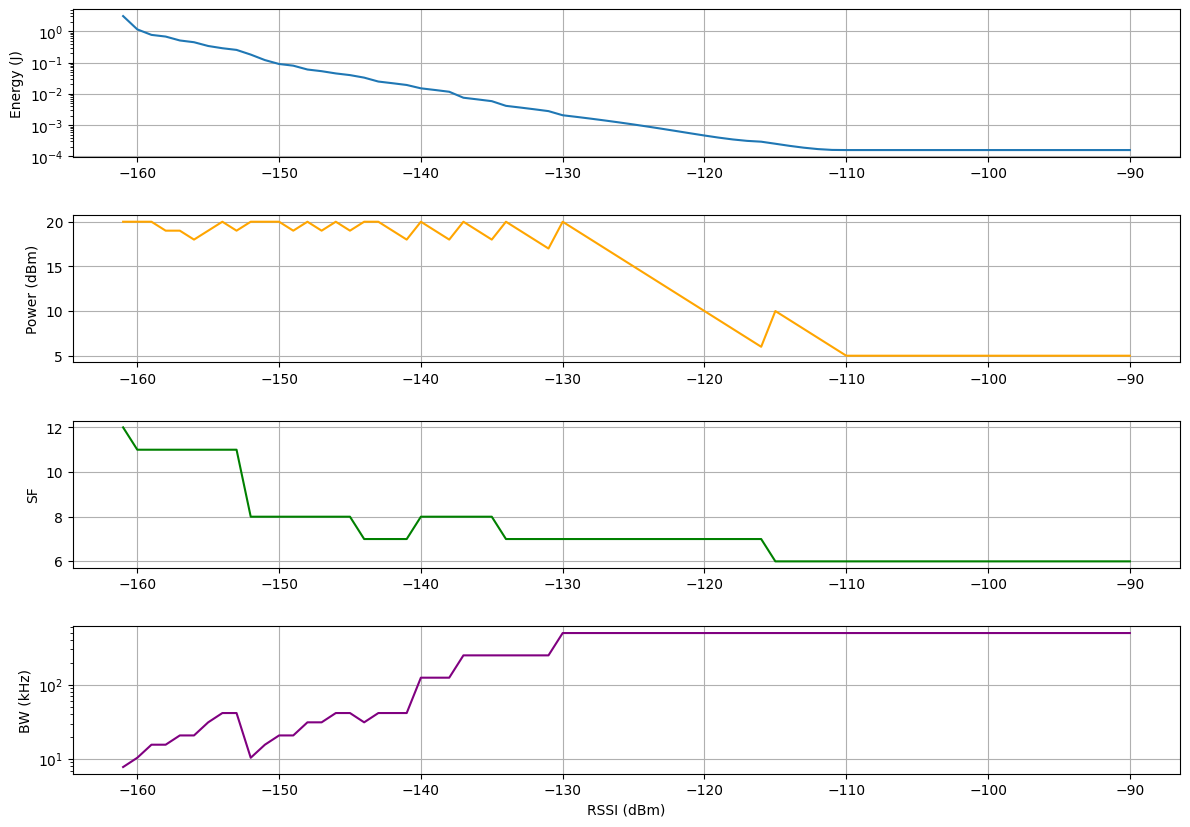

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
import random
import multiprocessing
import functools
from dataclasses import dataclass
import builtins

# === 1. CONFIGURAÇÕES ===
# Define os valores discretos que podem ser utilizados como genes
power_options = list(range(2, 21))  # Potência de transmissão em dBm
sf_options = list(range(6, 13))     # Spreading Factor de 6 a 12
bw_options = [7.8, 10.4, 15.6, 20.8, 31.25, 41.7, 62.5, 125.0, 250.0, 500.0]  # Larguras de banda em kHz

# Parâmetros de entrada do LoRa (fixo)
PAYLOAD_BYTES = 20  # Tamanho do payload em bytes
RSSI_MARGIN_MIN = 6  # Margem mínima de link em dB
CR_OPTION = 5  # Taxa de codificação padrão (4/5), opções: 5, 6, 7, 8

# Parêmetros do rádio LoRa
IH = 0  # Header explícito
CRC = 1  # CRC habilitado
DE = 0  # Otimização da taxa de dados desabilitada
PREAMBLE_SYMS = 8.0  # Número de símbolos do preâmbulo

# Evolução de parâmetros
POP_SIZE = 1000  # Tamanho da população
N_GEN = 25  # Número de gerações

@dataclass
class LoRaParams:
    power: int
    sf: int
    bw: float

@dataclass
class LoRaResult:
    rssi: int
    params: LoRaParams
    energy: float
    rs: float
    ts: float

# === 2. MODELO DE SENSIBILIDADE ===
def calculate_sensitivity(sf, bw):
    # Retorna a sensibilidade estimada do LoRa para SF e BW dados
    sensitivity_table = {
        (6, 125.0): -118, (7, 125.0): -123, (8, 125.0): -126, (9, 125.0): -129, (10, 125.0): -132, (11, 125.0): -134, (12, 125.0): -136,
        (6, 250.0): -115, (7, 250.0): -120, (8, 250.0): -123, (9, 250.0): -125, (10, 250.0): -128, (11, 250.0): -130, (12, 250.0): -133,
        (6, 500.0): -111, (7, 500.0): -116, (8, 500.0): -119, (9, 500.0): -122, (10, 500.0): -125, (11, 500.0): -128, (12, 500.0): -130,
        (6, 62.5): -121, (7, 62.5): -126, (8, 62.5): -129, (9, 62.5): -132, (10, 62.5): -135, (11, 62.5): -137, (12, 62.5): -139,
        (6, 10.4): -131, (7, 10.4): -134, (8, 10.4): -138, (11, 10.4): -146,
        (11, 7.8): -145, (12, 7.8): -148
    }
    # Interpola caso não exista na tabela
    key = (sf, bw)
    if key in sensitivity_table:
        return sensitivity_table[key]
    known = [(k[1], v) for k, v in sensitivity_table.items() if k[0] == sf]
    if not known:
        raise ValueError(f"No sensitivity data for SF={sf}")
    known.sort()
    for i in range(len(known) - 1):
        bw0, s0 = known[i]
        bw1, s1 = known[i + 1]
        if bw0 <= bw <= bw1:
            return np.interp(bw, [bw0, bw1], [s0, s1])
    return known[-1][1] if bw > known[-1][0] else known[0][1]

# === 2B. TABELA POTÊNCIA x CORRENTE ===
def power_to_current(power):
    # Converte potência em dBm para consumo estimado em mA
    coeffs = [10.768, -1.689, 0.153, 0.00076]
    return max(0, coeffs[0] + coeffs[1]*power + coeffs[2]*power**2 + coeffs[3]*power**3)

# === 3. TEMPO DE TRANSMISSÃO ===
def symbol_rate(sf, bw):
    return (bw * 1000) / (2 ** sf)

def symbol_time(sf, bw):
    return 1 / symbol_rate(sf, bw)

def airtime(params: LoRaParams, payload_bytes):
    # Calcula o tempo total de transmissão
    tsym = symbol_time(params.sf, params.bw)
    t_preamble = (PREAMBLE_SYMS + 4.25) * tsym
    numerator = 8 * payload_bytes - 4 * params.sf + 28 + 16 * CRC - 20 * IH
    denominator = 4 * (params.sf - 2 * DE)
    n_payload = 8 + max(int(np.ceil(numerator / denominator)) * (CR_OPTION), 0)
    t_payload = n_payload * tsym
    return t_preamble + t_payload

# === 4. FUNÇÃO DE AVALIAÇÃO ===
def evaluate(ind, rssi_observed):
    # Avalia um indivíduo com base no consumo de energia e margem de link
    params = LoRaParams(*ind)
    if params.sf not in sf_options or params.bw not in bw_options or params.power not in power_options:
        return (1e9,)  # Penaliza indivíduos inválidos
    sensitivity = calculate_sensitivity(params.sf, params.bw)
    margin = params.power + rssi_observed - sensitivity
    time_on_air = airtime(params, PAYLOAD_BYTES)
    current_ma = power_to_current(params.power)
    voltage = 3.3
    energy = (current_ma / 1000) * voltage * time_on_air
    if margin < RSSI_MARGIN_MIN:
        energy += 1e6  # Penaliza margens de sinal abaixo do mínimo
    return (energy,)

# === 5. CONFIGURAÇÃO DE DEAP ===
# Define tipos de fitness e indivíduos
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

def build_toolbox(rssi):
    # Cria as funções do algoritmo genético: geração, cruzamento, mutação, seleção
    toolbox = base.Toolbox()
    toolbox.register("attr_power", lambda: random.choice(power_options))
    toolbox.register("attr_sf", lambda: random.choice(sf_options))
    toolbox.register("attr_bw", lambda: random.choice(bw_options))
    toolbox.register("individual", tools.initCycle, creator.Individual, (toolbox.attr_power, toolbox.attr_sf, toolbox.attr_bw), 1)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("mate", tools.cxTwoPoint)  # Cruzamento de dois pontos
    toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.2)  # Mutação embaralha os genes
    toolbox.register("select", tools.selTournament, tournsize=3)  # Seleção por torneio
    toolbox.register("evaluate", functools.partial(evaluate, rssi_observed=rssi))  # Função de avaliação
    toolbox.register("map", builtins.map)
    return toolbox

# === 6. EXECUÇÃO PRINCIPAL ===
def run_optimization(rssi):
    # Executa a evolução genética
    toolbox = build_toolbox(rssi)
    pop = toolbox.population(n=POP_SIZE)  # Inicializa população
    hof = tools.HallOfFame(1)  # Guarda o melhor indivíduo encontrado
    # Algoritmo genético simples: evolui por N_GEN gerações com cruzamento e mutação
    algorithms.eaSimple(pop, toolbox, cxpb=0.7, mutpb=0.3, ngen=N_GEN, halloffame=hof, verbose=False)
    best = hof[0]
    params = LoRaParams(*best)
    energy = evaluate(best, rssi)[0]
    rs = symbol_rate(params.sf, params.bw)
    ts = symbol_time(params.sf, params.bw)
    return LoRaResult(rssi, params, energy, rs, ts)

# Função para plotar os resultados da otimização
def plot_results(resultados):
    rssi_list = [r.rssi for r in resultados]
    energy_list = [r.energy for r in resultados]
    power_list = [r.params.power for r in resultados]
    sf_list = [r.params.sf for r in resultados]
    bw_list = [r.params.bw for r in resultados]
    plt.figure(figsize=(12, 10))

    plt.subplot(5, 1, 1)
    plt.plot(rssi_list, energy_list)
    plt.ylabel('Energy (J)')
    plt.yscale('log')
    plt.grid(True)
    
    plt.subplot(5, 1, 2)
    plt.plot(rssi_list, power_list, color='orange')
    plt.ylabel('Power (dBm)')
    plt.grid(True)
    
    plt.subplot(5, 1, 3)
    plt.plot(rssi_list, sf_list, color='green')
    plt.ylabel('SF')
    plt.grid(True)
    
    plt.subplot(5, 1, 4)
    plt.plot(rssi_list, bw_list, color='purple')
    plt.ylabel('BW (kHz)')
    plt.yscale('log')
    plt.grid(True)
    
    plt.xlabel('RSSI (dBm)')
    plt.tight_layout()
    plt.show()

# Loop principal para executar a otimização para uma gama de RSSIs
def main():
    rssi_values = np.arange(-161, -89, 1)
    with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        resultados = pool.map(run_optimization, rssi_values)
    plot_results(resultados)

if __name__ == '__main__':
    main()
